In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
sns.set_theme()

# Знакомство с данными и их предобработка

![Red Wine Quality](red_wine.jpg)

Загрузим данные о красном ([Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)) и белом вине ([White Wine Quality](https://www.kaggle.com/datasets/piyushagni5/white-wine-quality)) для задачи классификации. Создадим новый целевой признак `target` и объединим два датасета в один `DataFrame`.

In [3]:
df_wine_red = pd.read_csv('./winequality-red.csv')
df_wine_white = pd.read_csv('./winequality-white.csv', sep=';')

df_wine_red['target'] = 1
df_wine_white['target'] = 0

df = pd.concat([df_wine_red, df_wine_white])

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  target                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


In [5]:
df.target.value_counts()

target
0    4898
1    1599
Name: count, dtype: int64

Обнаружим, что классы в данных не сбалансированы. Количество экземпляров с красным вином примерно в три раза меньше, чем количество экземпляров с белым вином.

Проведем разделение данных на обучающую и валидационную выборки.

In [6]:
features = df.drop(['target'], axis=1)
target = df['target']

In [7]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=1)

# Реализация собственной метрики качества *balanced_accuracy_score*

Метрика `balanced_accuracy_score` (сбалансированная метрика точности) используется для оценки качества моделей в случае несбалансированных данных, где число примеров в разных классах существенно различается. В случае бинарной классификации сбалансированная точность (`balanced accuracy`) может быть определена как среднее арифметическое между чувствительностью (`true positive rate`) и специфичностью (`true negative rate`). Метрика находится в диапазоне от 0 до 1, где значение 0 соответствует случайным предсказаниям, а значение 1 соответствует идеальным предсказаниям.

$$balanced\;accuracy = \frac{1}{2}\Bigr(\frac{TP}{TP+FN} + \frac{TN}{TN+FP}\Bigl)$$
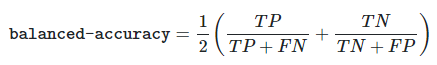

Напишем собственную реализацию сбалансированной метрики точности и сравним ее с библиотечной реализацией.

In [8]:
def balanced_accuracy_score_my(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred) # Матрица ошибок
    
    num_classes = cm.shape[0] # Количество классов
    
    tp_and_tn = cm.diagonal() # Количество верно предсказанных положительных и отрицательных примеров
    fn_and_fp = cm.sum(axis=1) - tp_and_tn # Количество неверно предсказанных положительных и отрицательных примеров
    
    accuracy = tp_and_tn / (tp_and_tn + fn_and_fp) # Точность
    
    score = sum(accuracy) / num_classes # Сбалансированная метрика точности
    
    return score

Для проверки корректности нашей реализации сравним значения, полученные с помощью библиотечной реализации и нашей собственной реализации.

In [9]:
y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

print(f'Библиотечная сбалансированная точность: {balanced_accuracy_score(y_true, y_pred)}')
print(f'Собственная реализация сбалансированной точности: {balanced_accuracy_score_my(y_true, y_pred)}')

Библиотечная сбалансированная точность: 0.6071428571428572
Собственная реализация сбалансированной точности: 0.6071428571428572


Результаты идентичные.

# Обучение модели решающего дерева и выбор лучших гиперпараметров

Подберем лучшую модель решающего дерева, варьируя гиперпараметр модели `min_samples_leaf` (минимальное количество объектов в листе) от `1` до `30`.

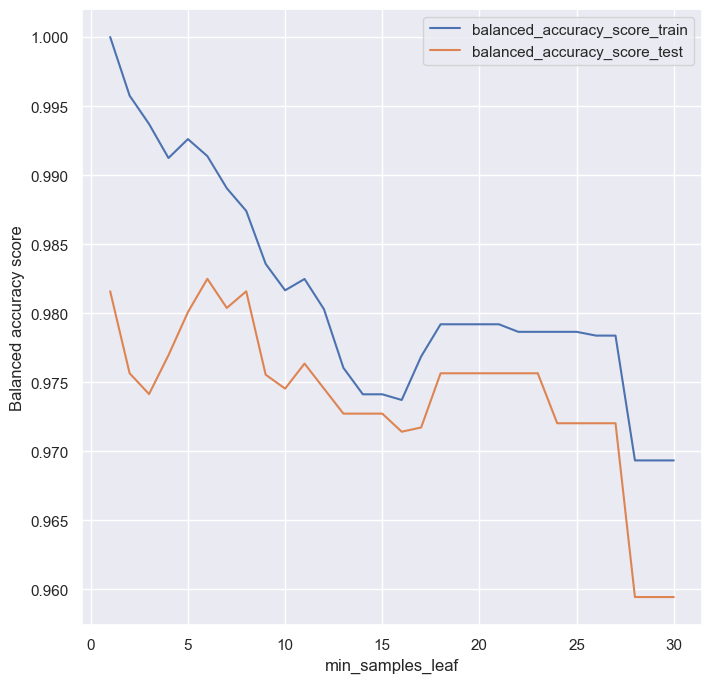

In [10]:
res = []

for param in range(1, 31):
    model = DecisionTreeClassifier(min_samples_leaf=param, random_state=1)
    
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    res.append([param, balanced_accuracy_score_my(target_train, pred_train),
                balanced_accuracy_score_my(target_test, pred_test)])
    
res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'balanced_accuracy_score_train', 'balanced_accuracy_score_test'])

plt.figure(figsize=(8, 8))

sns.lineplot(data=res_pd.set_index('min_samples_leaf')['balanced_accuracy_score_train'], label='balanced_accuracy_score_train')
sns.lineplot(data=res_pd.set_index('min_samples_leaf')['balanced_accuracy_score_test'], label='balanced_accuracy_score_test')

plt.legend()

plt.ylabel('Balanced accuracy score')

plt.show();

Можно заметить, что существует значительная разница в качестве между обучающей и валидационной выборками при использовании небольших и больших значений `min_samples_leaf`. Это является признаком переобучения модели. Кроме того, когда количество объектов в листе превышает примерно 28, наблюдается плато в качестве, что также указывает на переобучение. Наиболее схожее качество между обучающей и валидационной выборками наблюдается при использовании 10-20 объектов в листе.

In [11]:
res_pd[res_pd['balanced_accuracy_score_test'] == res_pd['balanced_accuracy_score_test'].max()]

,min_samples_leaf,balanced_accuracy_score_train,balanced_accuracy_score_test
5,6,0.991374,0.982486


Наилучшее качество модели на валидационной выборке (`balanced_accuracy_score_test = 0.982486`) достигается при использовании значения `min_samples_leaf = 6`.

# Обучение модели случайного леса и выбор лучших гиперпараметров

Подберем лучшую модель случайного леса, варьируя гиперпараметры модели `min_samples_leaf` (минимальное количество объектов в листе) и `n_estimators` (количество базовых классификаторов) от 1 до 10. Для визуализации результатов построим тепловую карту `imshow`.

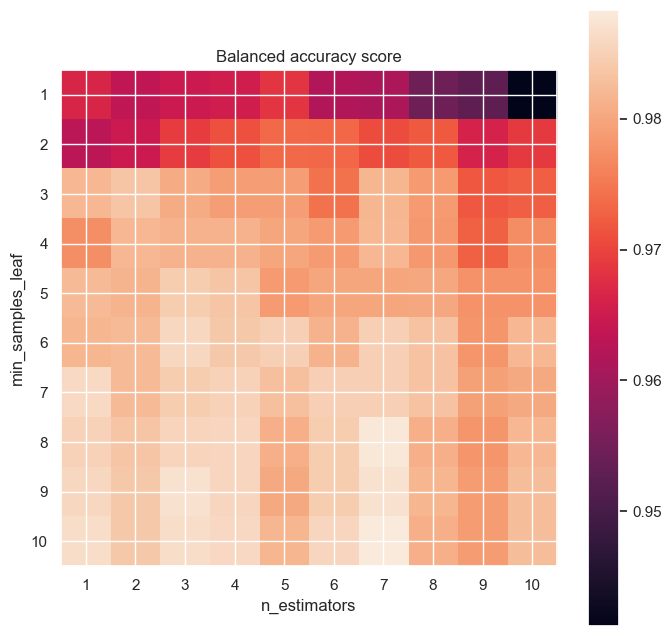

In [12]:
res = []

for n_tree in range(1, 11):
    for param in range(1, 11):
        model = RandomForestClassifier(n_estimators=n_tree, min_samples_leaf=param, random_state=1)
        
        model.fit(features_train, target_train)
        
        pred_test = model.predict(features_test)
        
        res.append([n_tree, param, balanced_accuracy_score_my(target_test, pred_test)])
    
res_pd = pd.DataFrame(res, columns=['n_estimators', 'min_samples_leaf', 'balanced_accuracy_score_test'])

pivot_table = res_pd.pivot(index='n_estimators', columns='min_samples_leaf', values='balanced_accuracy_score_test')

plt.figure(figsize=(8, 8))

plt.imshow(pivot_table.values, aspect=True)

plt.colorbar()
plt.xticks(range(len(pivot_table.index)), pivot_table.index)
plt.yticks(range(len(pivot_table.columns)), pivot_table.columns)

plt.title('Balanced accuracy score')
plt.xlabel('n_estimators')
plt.ylabel('min_samples_leaf')

plt.show()

Одной из особенностей является то, что при использовании небольших значений `min_samples_leaf` наблюдается наихудшая точность. Из этого можно сделать вывод, что реализация слишком сложных базовых моделей не имеет смысла. Вместо этого лучше создавать более простые базовые модели, но в большем количестве.

In [13]:
res_pd[res_pd['balanced_accuracy_score_test'] == res_pd['balanced_accuracy_score_test'].max()]

,n_estimators,min_samples_leaf,balanced_accuracy_score_test
96,10,7,0.988322


Наилучшее качество модели на валидационной выборке (`balanced_accuracy_score_test = 0.988322`) достигается при использовании значений `min_samples_leaf = 7` и `n_estimators = 10`.

# Обучение модели градиентного бустинга и выбор лучших гиперпараметров

Выделим из обучающей части данных часть для валидации градиентного бустинга.

In [14]:
features_train_xgb, features_val, target_train_xgb, target_val = train_test_split(features_train,
                                                                                  target_train,
                                                                                  test_size=0.15,
                                                                                  random_state=1)

Реализуем функцию для обучения градиентного бустинга.

In [15]:
def gradient_boosting_training(n_tree, depth, lr, early_stopping=False):
    model = XGBClassifier(n_estimators=n_tree, max_depth=depth, learning_rate=lr, early_stopping_rounds=early_stopping)

    model.fit(features_train_xgb, target_train_xgb,
              eval_set=[(features_train_xgb, target_train_xgb), (features_val, target_val)],
              verbose=0)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    print(f'\nСбалансированная точность на обучающей выборке: {balanced_accuracy_score_my(pred_train, target_train)}')
    print(f'Сбалансированная точность на тестовой выборке: {balanced_accuracy_score_my(pred_test, target_test)}')

    epochs = len(model.evals_result()['validation_0']['logloss'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots(figsize=(8, 8))

    sns.lineplot(model.evals_result()['validation_0']['logloss'], label='Train')
    sns.lineplot(model.evals_result()['validation_1']['logloss'], label='Val')

    plt.xticks(x_axis)

    plt.title('XGBoost Logloss')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Logloss Deviance')
    plt.legend(loc='upper right');

Зафиксируем небольшое количество деревьев (`n_estimators = 5`), максимальную глубину дерева (`max_depth = 3`) и скорость обучения (`learning_rate = 0.8`). Обучим градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведем значение метрики качества на экран.


Сбалансированная точность на обучающей выборке: 0.9924342716725529
Сбалансированная точность на тестовой выборке: 0.9854873260310376


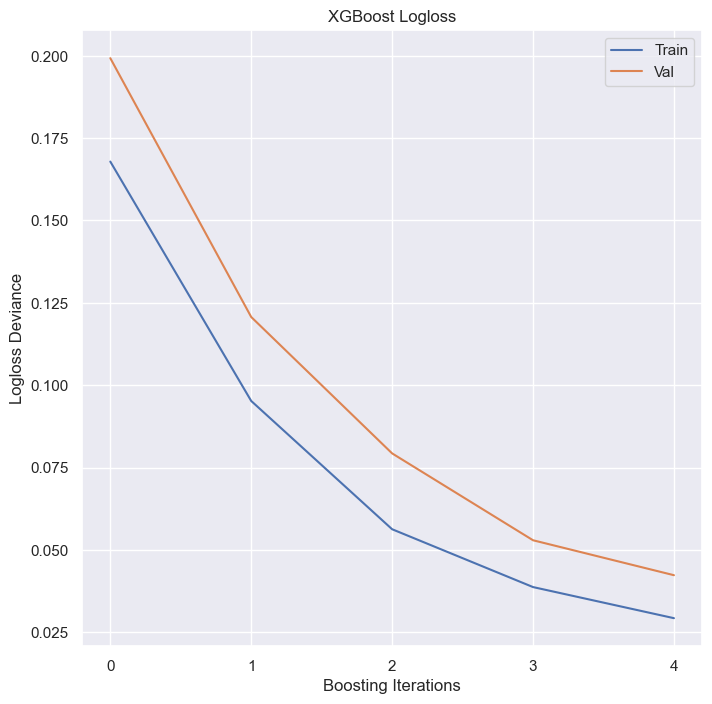

In [16]:
gradient_boosting_training(5, 3, 0.8)

Из графика видно, что функция потерь равномерно уменьшается как для обучающей выборки, так и для валидационной выборки. С выбранными гиперпараметрами точность на тестовой выборке получилась следующая: `balanced_accuracy_score = 0.9854873260310376`.

Подберем лучшую модель градиентного бустинга, варьируя гиперпараметры модели `max_depth` (максимальная глубина дерева) от 1 до 10 и `learning_rate` (скорость обучения) от 0.1 до 1.0. Для визуализации результатов построим тепловую карту `imshow`.

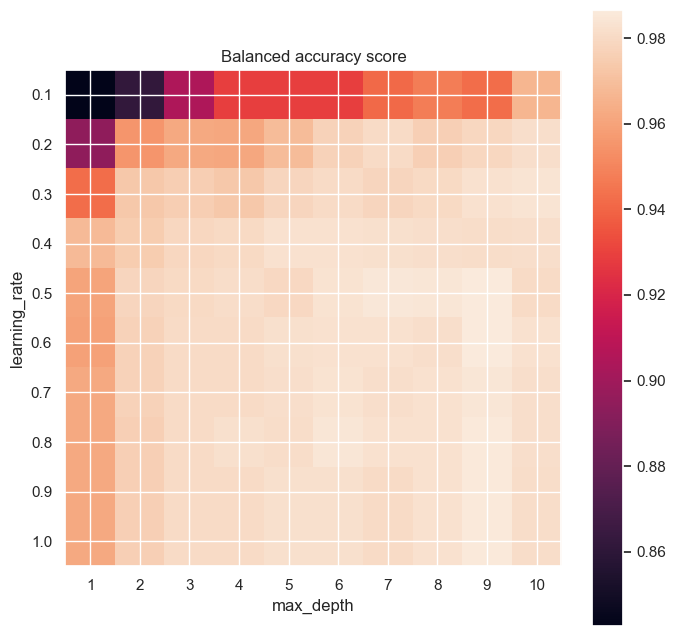

In [17]:
res = []

for param in range(1, 11):
    lr = 1
    
    while lr > 0:
        model = XGBClassifier(n_estimators=5, max_depth=param, learning_rate=lr)

        model.fit(features_train_xgb, target_train_xgb,
                  eval_set=[(features_train_xgb, target_train_xgb), (features_val, target_val)],
                  verbose=0)

        pred_train = model.predict(features_train)
        pred_test = model.predict(features_test)
        
        res.append([param, lr, balanced_accuracy_score_my(target_test, pred_test)])
        
        lr -= 0.1
        lr = np.round(lr, decimals=1)
    
res_pd = pd.DataFrame(res, columns=['max_depth', 'learning_rate', 'balanced_accuracy_score_test'])

pivot_table = res_pd.pivot(index='max_depth', columns='learning_rate', values='balanced_accuracy_score_test')

plt.figure(figsize=(8, 8))

plt.imshow(pivot_table.values, aspect=True)

plt.colorbar()
plt.xticks(range(len(pivot_table.index)), pivot_table.index)
plt.yticks(range(len(pivot_table.columns)), pivot_table.columns)

plt.title('Balanced accuracy score')
plt.xlabel('max_depth')
plt.ylabel('learning_rate')

plt.show()

Анализируя тепловую карту, можно сделать вывод, что при использовании небольшой скорости обучения наблюдается наихудшее качество модели.

In [18]:
res_pd[res_pd['balanced_accuracy_score_test'] == res_pd['balanced_accuracy_score_test'].max()]

,max_depth,learning_rate,balanced_accuracy_score_test
51,6,0.9,0.986611


Наилучшее качество модели на тестовой выборке (`balanced_accuracy_score_test = 0.986611`) достигается при использовании значений `max_depth = 6` и `learning_rate = 0.9`.

Увеличим количество деревьев.


Сбалансированная точность на обучающей выборке: 0.9994534025690079
Сбалансированная точность на тестовой выборке: 0.9915012962326515


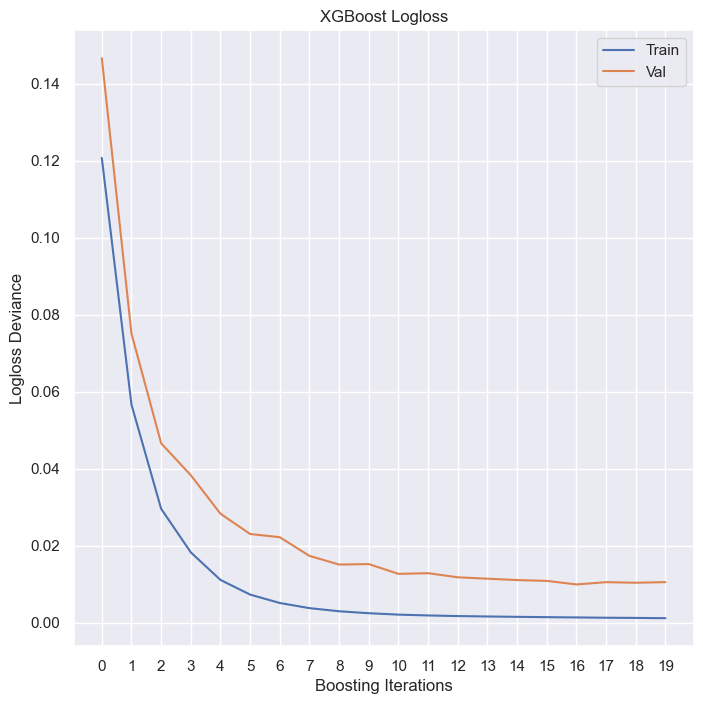

In [19]:
gradient_boosting_training(20, 6, 0.9)

Можно заметить, что при увеличении количества деревьев модель на десятой итерации обучения практически не улучшается, что может быть признаком переобучения. Для предотвращения этой ситуации можно использовать гиперпараметр `early_stopping_rounds`, который приостанавливает обучение модели, когда она не демонстрирует улучшения или ее производительность начинает ухудшаться на валидационной выборке. Это позволяет автоматически остановить обучение, когда достигнут оптимальный уровень точности модели, и таким образом, можно сэкономить время и ресурсы.


Сбалансированная точность на обучающей выборке: 0.9993169398907105
Сбалансированная точность на тестовой выборке: 0.9897775826003572


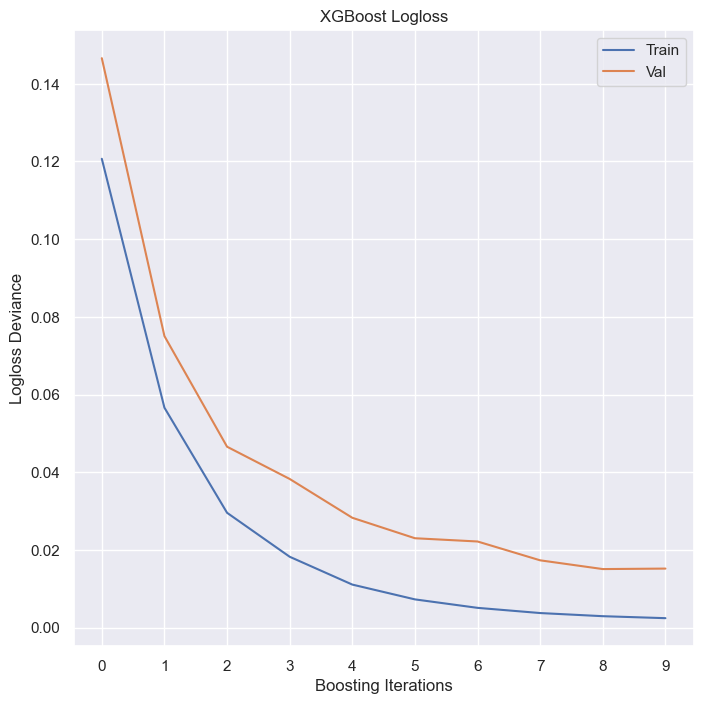

In [20]:
gradient_boosting_training(20, 6, 0.9, early_stopping=True)

Механизм `early stopping` успешно приостановил дальнейшее обучение модели после десятой итерации. Точность на тестовой выборке: `balanced_accuracy_score_test = 0.9897775826003572`.

Все обученные модели в процессе работы, а также их качество на тестовой выборке:

1) Решающее дерево: 0.982486.
2) Случайный лес: 0.988322.
3) Произвольный градиентный бустинг: 0.9854873260310376.
4) Градиентный бустинг: 0.986611.
5) Градиентный бустинг после увеличения деревьев: 0.9897775826003572.

После увеличения числа базовых классификаторов градиентный бустинг продемонстрировал наилучшие результаты, достигнув сбалансированной точности 0.9897775826003572, используя значения гиперпараметров:
- `n_estimators` (количество деревьев): 20;
- `max_depth` (максимальная глубина дерева): 6;
- `learning_rate` (скорость обучения): 0.9.

# Вывод

В ходе исследования данные были предобработаны для последующего обучения моделей. Также была изучена и реализована метрика качества `balanced_accuracy_score`. Для улучшения производительности моделей были проведены обучения с различными гиперпараметрами. В результате, градиентный бустинг продемонстрировал наилучшую эффективность с высокой сбалансированной точностью, достигнув значения 0.9897775826003572, что близко к идеальным предсказаниям.